# Outline

#### 1. Exploratory data analysis (EDA)

1.1 Basic statistics

1.2 Column without meaning / constant value

1.3 Categorical variables: Distinct columns values

1.4 Continuous variables: Plotting distributions

#### 2. Preprocessing and Feature Engineering (functions)

2.1 Handle Missing Values 

2.2 Handle outliers

2.3 Drop features 

2.4 Text processing 

2.5 Encoding categorical variables 


#### 3. Answering the challenges
#### 4. Tests

Zhaoxue Li 2023 April 6th

# 0. Import libraries and read data

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder. \
    appName("pyspark-1"). \
    getOrCreate()

from pyspark.sql import DataFrame, Column
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window

from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer)


### Read data

In [64]:
# Upon first inspecting the dataframe using default load options, 
# I found that the data is not parsed correctly due to commas and quotes in fields.
# Adding quotes option solved it

df = spark.read.options(header=True, inferSchema=True)\
.option("quote", "\"")\
.option("escape", "\"")\
.csv("/dataset/nyc-jobs.csv")

In [65]:
print('There are {} rows in dataframe'.format(df.count()))
print('---------------------------------')
print('Below is the dataframe schema:')
df.printSchema()

There are 2946 rows in dataframe
---------------------------------
Below is the dataframe schema:
root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)


# 1.EDA

### 1.1 Basic Statistics 

In [12]:
# Convert the spark dataframe to pandas dataframe to use the built-in statistics functions
pandas_df = df.toPandas()
pandas_df.describe()

,Job ID,# Of Positions,Salary Range From,Salary Range To
count,2946.000000,2946.000000,2946.000000,2946.000000
mean,384821.563136,2.495927,58904.139794,85535.711627
std,53075.338977,9.281313,26986.575936,42871.313454
min,87990.000000,1.000000,0.000000,10.360000
25%,378496.750000,1.000000,49390.000000,62000.000000
50%,404382.000000,1.000000,58440.000000,82056.000000
75%,419974.250000,1.000000,73171.750000,106222.000000
max,426238.000000,200.000000,218587.000000,234402.000000


In [13]:
# Datatypes and null values of each column 
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2946 entries, 0 to 2945
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Job ID                         2946 non-null   int32         
 1   Agency                         2946 non-null   object        
 2   Posting Type                   2946 non-null   object        
 3   # Of Positions                 2946 non-null   int32         
 4   Business Title                 2946 non-null   object        
 5   Civil Service Title            2946 non-null   object        
 6   Title Code No                  2946 non-null   object        
 7   Level                          2946 non-null   object        
 8   Job Category                   2944 non-null   object        
 9   Full-Time/Part-Time indicator  2751 non-null   object        
 10  Salary Range From              2946 non-null   float64       
 11  Salary Range To  

> EDA finding 1: Of the important numeric value Salary Range, there is very big variance. There might be data quality issue becuase the min salary ranges from 0

> EDA finding 2: Columns ['Additional information','Hours/Shift','Work Location 1','Recruitment Contact','Post Until'] have significant portion missing, or completely missing values. Consider dropping these columns

> EDA finding 3: Other columns with missing values, consider imputing 

### 1.2 Columns without meaning / with constant values

In [6]:
for i in pandas_df.columns:
    if len(pandas_df[i].unique()) == 1:
        print('EDA finding 4: {} is a column which only has 1 value {}. Need to drop column'.format(i,pandas_df[i].unique()))

EDA finding 4: Recruitment Contact is a column which only has 1 value [None]. Need to drop column


### 1.3 Categorical values

In [14]:
# create lists of categorical and numerical column names
numerical_columns = [i for i in pandas_df.columns if (pandas_df[i].dtypes == "float64" or pandas_df[i].dtypes == "int32")]
categorical_columns = [i for i in pandas_df.columns if pandas_df[i].dtypes == "object"]

In [15]:
# Check the most frequent appearing categories in each field

for colname in categorical_columns:
    print(colname)
    df.groupBy(colname).count().sort('count',ascending=False).show(30,truncate=False)

Agency
+------------------------------+-----+
|Agency                        |count|
+------------------------------+-----+
|DEPT OF ENVIRONMENT PROTECTION|655  |
|NYC HOUSING AUTHORITY         |231  |
|DEPT OF HEALTH/MENTAL HYGIENE |188  |
|DEPARTMENT OF TRANSPORTATION  |183  |
|DEPT OF DESIGN & CONSTRUCTION |142  |
|TAXI & LIMOUSINE COMMISSION   |134  |
|ADMIN FOR CHILDREN'S SVCS     |108  |
|DEPT OF INFO TECH & TELECOMM  |107  |
|LAW DEPARTMENT                |95   |
|HOUSING PRESERVATION & DVLPMNT|86   |
|OFFICE OF THE COMPTROLLER     |64   |
|POLICE DEPARTMENT             |64   |
|OFFICE OF MANAGEMENT & BUDGET |58   |
|NYC EMPLOYEES RETIREMENT SYS  |54   |
|DEPARTMENT OF INVESTIGATION   |53   |
|DEPARTMENT OF BUSINESS SERV.  |52   |
|DEPARTMENT OF CORRECTION      |51   |
|DEPT OF PARKS & RECREATION    |48   |
|DEPARTMENT OF CITY PLANNING   |45   |
|DEPT OF CITYWIDE ADMIN SVCS   |42   |
|DEPARTMENT OF SANITATION      |40   |
|DEPT OF YOUTH & COMM DEV SRVS |38   |
|DEPARTMENT FOR TH

+-----------------------------+-----+
|Full-Time/Part-Time indicator|count|
+-----------------------------+-----+
|F                            |2625 |
|null                         |195  |
|P                            |126  |
+-----------------------------+-----+

Salary Frequency
+----------------+-----+
|Salary Frequency|count|
+----------------+-----+
|Annual          |2712 |
|Hourly          |195  |
|Daily           |39   |
+----------------+-----+

Work Location
+------------------------------+-----+
|Work Location                 |count|
+------------------------------+-----+
|96-05 Horace Harding Expway   |262  |
|59-17 Junction Blvd Corona Ny |206  |
|30-30 Thomson Ave L I City Qns|142  |
|1 Centre St., N.Y.            |123  |
|55 Water St Ny Ny             |120  |
|33 Beaver St, New York Ny     |110  |
|255 Greenwich Street          |96   |
|100 Church St., N.Y.          |88   |
|100 Gold Street               |86   |
|150 William Street, New York N|76   |
|42-09 28th Street 

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Hours/Shift                                                                                                                                                                                             |count|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|null                                                                                                                                                                                                    |2062 |
|35 Hours                                                                                                                                                           

+-------------------+-----+
|Recruitment Contact|count|
+-------------------+-----+
|null               |2946 |
+-------------------+-----+

Residency Requirement
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Residency Requirement             

> EDA finding: There are columns with very hig cardinality 

> For visualization purposes, we will plot the categorical values with top 10 number of postings

> 'Titile code no' is redundant information, drop this column later

In [32]:
# Count plot
colname = 'Job Category'
subset = df.groupBy(colname).agg(count('Job Category').alias('Count')).sort('Count',ascending=False).limit(10)
df_to_plot = subset.toPandas()
df_to_plot.head()


,Job Category,Count
0,"Engineering, Architecture, & Planning",504
1,"Technology, Data & Innovation",313
2,Legal Affairs,226
3,"Public Safety, Inspections, & Enforcement",182
4,Building Operations & Maintenance,181


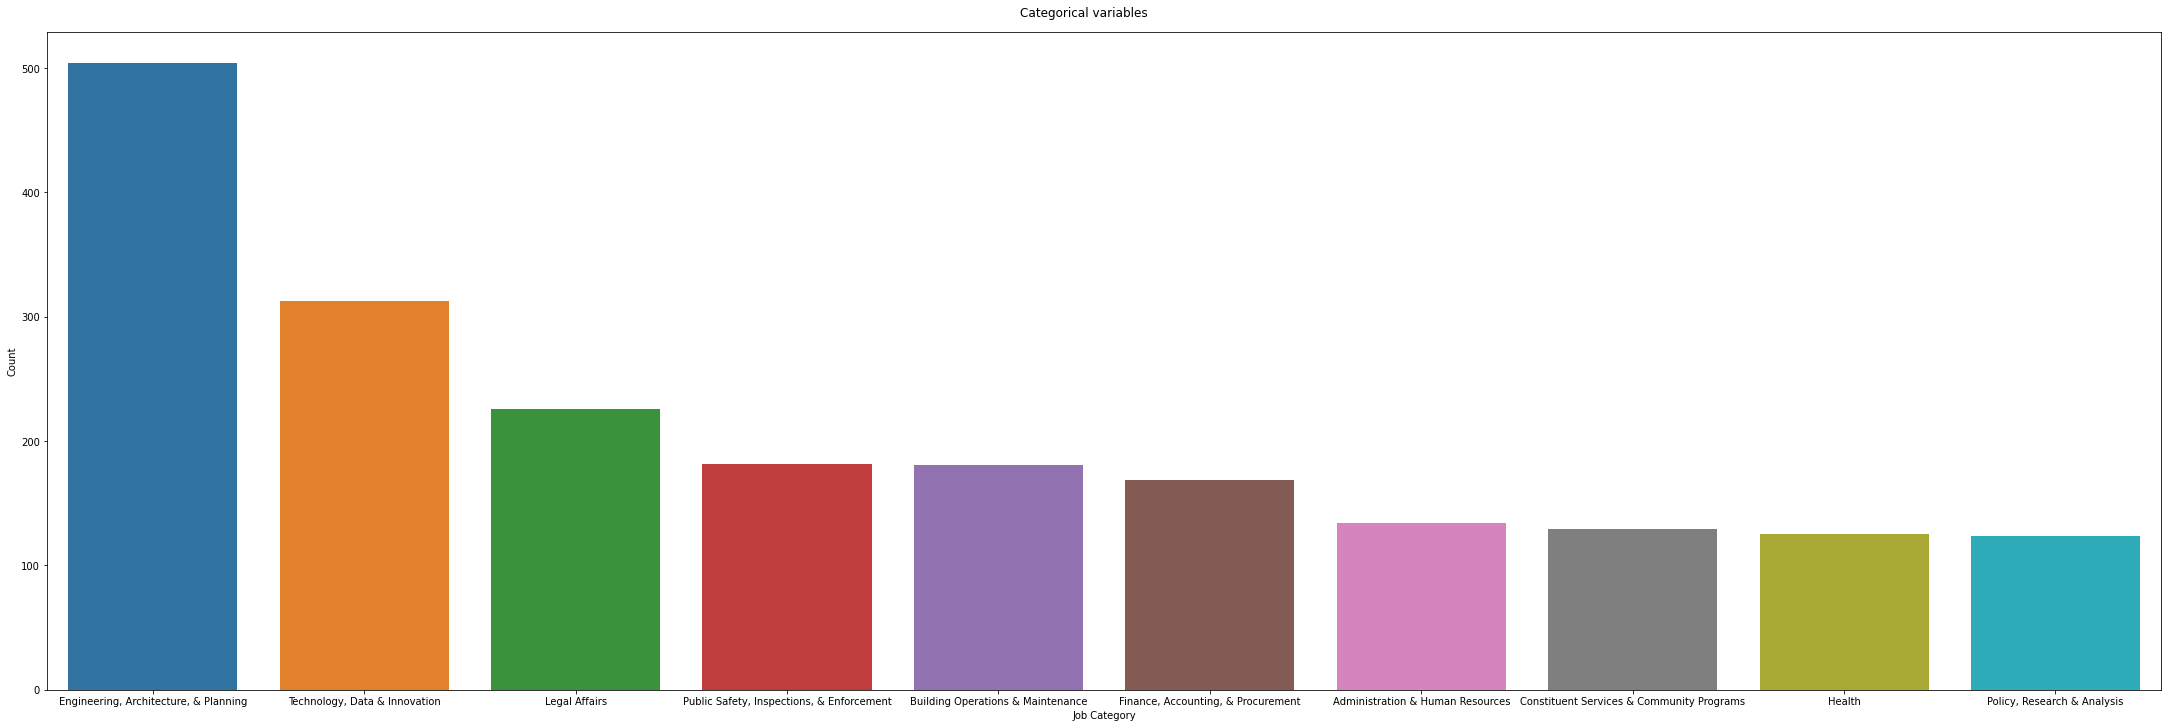

In [42]:
fig, axs = plt.subplots(constrained_layout=True)
fig.set_size_inches(30,10)
fig.suptitle('Categorical variables')

sns.barplot(
    data=df_to_plot,
    x=colname,
    y='Count',
    capsize=.4
    )
plt.show()

### 1.4 Plot continuous variables

**Note:** 

- No null in salary column

- Since there are 3 salary frequencies, all salary number need to be scaled to hourly basis

- Add columns salary_floor_hourly and salary_ceiling_hourly

- Assumption: 8 working hours per day, 22 working days per month 

- Annual salary -> salary / (22*12*8)

- Daily salary -> salary / (8)

In [43]:
# Could define a udf to create normalized salary columns
# 

# def salary_converter(frequency: StringType) -> int:
#     annual_working_hours = 2112  # 12*22*8 12 months * 22 days * 8 hours 
#     daily_working_hours = 8 
# #     if frequency == 'Annual':
# #         return annual_working_hours
# #     elif frequency == 'Daily':
# #         return daily_working_hours
# #     else:
# #         return 1 
#     return 1 

**Density plots on all salary - scaled to hourly rate**

In [66]:
normalized_df = df.\
withColumn("hourly_salary_floor",
           expr("""`Salary Range From`/(case when `Salary Frequency` = 'Annual' then 2112 
                           when `Salary Frequency` = 'Daily' then 8 
                           else 1 end)""")).\
withColumn("hourly_salary_ceil",
           expr("""`Salary Range To`/(case when `Salary Frequency` = 'Annual' then 2112 
                           when `Salary Frequency` = 'Daily' then 8 
                           else 1 end)"""))

In [45]:
salary_plot_df = normalized_df.\
select('Job Category','hourly_salary_floor', 'hourly_salary_ceil').toPandas()

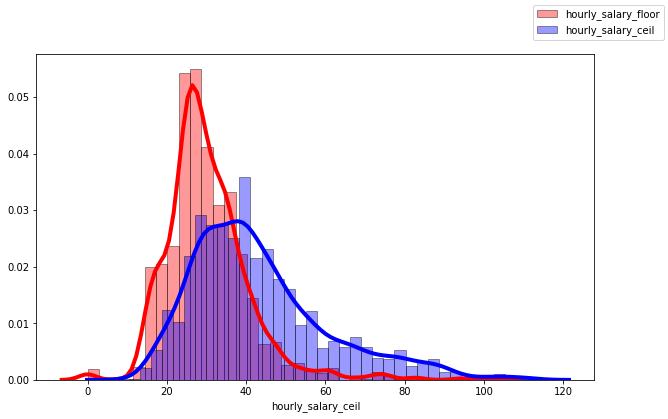

In [15]:
fig = plt.figure(figsize=(10,6))
sns.distplot(salary_plot_df['hourly_salary_floor'], 
             hist=True, 
             kde=True, 
             bins=int(180/5), color = 'red', 
             label='hourly_salary_floor',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

sns.distplot(salary_plot_df['hourly_salary_ceil'],
             hist=True,
             kde=True,
             bins=int(180/5), color = 'blue',
             label='hourly_salary_ceil',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
fig.legend()
plt.show()

> Both salary distributions are unimodal, and skewed to the right. Salary_floor field has less variance than salary_ceiling, which suggests the upper bound of salary could be widely dispersed.

> There are cases where hourly_salary_floor = 0: this doesn't seem to be correct. To be investigated.

**Density Plot by Job Categories**

Text(0, 0.5, 'Density')

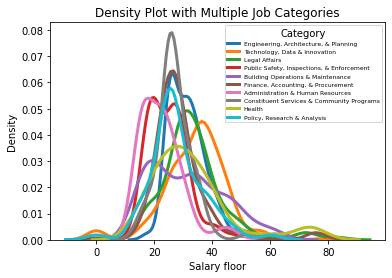

In [46]:
categories = ['Engineering, Architecture, & Planning',
              'Technology, Data & Innovation',
              'Legal Affairs',
              'Public Safety, Inspections, & Enforcement',
              'Building Operations & Maintenance',
              'Finance, Accounting, & Procurement',
              'Administration & Human Resources',
              'Constituent Services & Community Programs',
              'Health',
              'Policy, Research & Analysis']

for category in categories:
    # Subset to the category
    subset = salary_plot_df[salary_plot_df['Job Category'] == category]
    
    # Draw the density plot
    sns.distplot(subset['hourly_salary_floor'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = category)
    
# Plot formatting
plt.legend(prop={'size': 6}, title = 'Category')
plt.title('Density Plot with Multiple Job Categories')
plt.xlabel('Salary floor')
plt.ylabel('Density')

> Job Category has different salary distributions. In both variance and central tendancy.

#### Boxplot by single job category

In [16]:
# subset = salary_plot_df[salary_plot_df['Job Category'] == category]

# 2. Preprocessing and Feature Engineering

### 2.1 Handle Missing Values

**Heuristic: if a column has more than 50% null values, drop that column, otherwise we try to impute**

**Imputation strategy:**

- Job Category: 2 rows -> since it's only 2 rows, either drop or fill with 'na'

- Full-Time/Part-Time indicator: Jobs with annual salary are usually Full-time, we can use this general observation to fill the column 

- Minimum Qual Requirements: optional column, fill with 'na'

- Preferred Skills: optional column, fill with 'na'

- To Apply : either drop or fill 'na'

- Residency Requirement: optional column, fill with 'na'

- Date columns: Posting Date,Posting Updated,Process Date -> '1970-01-01'

**Note that we are dealing with true null values(null, nan, nat), not including '', 'Null','None'

In [107]:
def handle_null_values(df:DataFrame) -> DataFrame:
    cleaned_df = df \
    .withColumn('Time indicator',expr("case when `Salary Frequency` == 'Annual' then 'F' else 'P' end")) \
    .withColumn('Posting Date Cleaned',when(col('Posting Date').isNull(),'1970-01-01').otherwise(col('Posting Date'))) \
    .withColumn('Posting Updated Cleaned',when(col('Posting Updated').isNull(),'1970-01-01').otherwise(col('Posting Updated'))) \
    .withColumn('Process Date Cleaned',when(col('Process Date').isNull(),'1970-01-01').otherwise(col('Process Date'))) \
    .na.fill('na')
    return cleaned_df

In [108]:
# Check that there are no more null values
clean_df = handle_null_values(normalized_df)
clean_df = clean_df.drop('Additional information','Hours/Shift','Work Location 1',
          'Recruitment Contact','Post Until','Full-Time/Part-Time indicator',
         'Posting Date','Posting Updated','Process Date') 
clean_df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = false)
 |-- Posting Type: string (nullable = false)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = false)
 |-- Civil Service Title: string (nullable = false)
 |-- Title Code No: string (nullable = false)
 |-- Level: string (nullable = false)
 |-- Job Category: string (nullable = false)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = false)
 |-- Work Location: string (nullable = false)
 |-- Division/Work Unit: string (nullable = false)
 |-- Job Description: string (nullable = false)
 |-- Minimum Qual Requirements: string (nullable = false)
 |-- Preferred Skills: string (nullable = false)
 |-- To Apply: string (nullable = false)
 |-- Residency Requirement: string (nullable = false)
 |-- hourly_salary_floor: double (nullable = true)
 |-- hourly_salary_ceil: double (nullable = true)
 |--

In [83]:
# scan the dataframe to see there are no null values 
count_null = 0
for column in clean_df.columns:
    n = clean_df.filter(col(column).isNull()).count()
    count_null += n
    
assert count_null == 0

### 2.2 Drop features

**In order to eliminate features, we need to study the correlations and associations between features, and with target. For instance if we want to predict the salary of a job posting, we might drop the columns that are weakly correlated with salary**

**Apart from manually select features, we can analyze feature importance automatically using machine learning techniques or feature selection libraries, which is not covered in this notebook.**

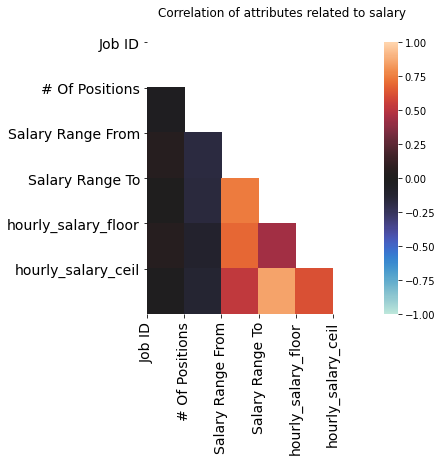

In [88]:
# plotting the correlation in python 
import numpy as np

feature_cols = [i for i in normalized_pandas_df.columns if (normalized_pandas_df[i].dtypes == "float64" or normalized_pandas_df[i].dtypes == "int32")]

df_corr = clean_df.toPandas()[feature_cols].corr()
mask = np.triu(np.ones_like(df_corr))

fig, ax = plt.subplots(figsize = (5,5))
fig.suptitle('Correlation of attributes related to salary')
sns.heatmap(df_corr,mask=mask,cmap='icefire',fmt='.2f',vmin=-1,vmax=1)

plt.xticks(range(normalized_pandas_df[feature_cols].shape[1]), normalized_pandas_df[feature_cols].columns, fontsize=14, rotation=90)
plt.yticks(range(normalized_pandas_df[feature_cols].shape[1]), normalized_pandas_df[feature_cols].columns, fontsize=14)
plt.show()

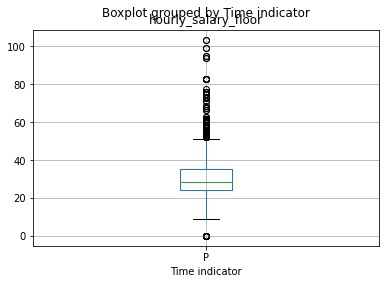

In [90]:
feature_col = 'Time indicator'

clean_df.toPandas().boxplot(column='hourly_salary_floor',by=feature_col,)

In [85]:
# Drop columns that don't possess unique meaning: Job ID, Title Code No, To Apply
# we already created normalized salary features, therefore we can drop these two columns
denoise_df = clean_df.drop('Salary Range From','Salary Range To','Job ID',' Title Code No','To Apply')
denoise_pandas_df = denoise_df.toPandas()

### 2.3 Handle Outliers

When it comes to feature enginnering ( beyond the most basics), there are many ways, some are heuristic based, some are machine learning based. Here I applied pretty basic techniques.

For outlier removal, we can remove data beyond IQR * 1.5, we can use IsolationForest from scikit-learn library

**After inspecting the data, although there are outliers, the ones needs special handling are where the salary floor is 0. Having 0 as annual minimum salary is weird. It makes more sense for salary to be set per hour or per day if this is a part-time position**

In [118]:
denoise_df.select('Business Title','Job Category','Time indicator','Level','Salary Frequency')\
.filter(col('hourly_salary_floor')==0) \
.show()

+--------------------+--------------------+--------------+-----+----------------+
|      Business Title|        Job Category|Time indicator|Level|Salary Frequency|
+--------------------+--------------------+--------------+-----+----------------+
|Cybersecurity Sen...|Technology, Data ...|             P|    0|          Annual|
|Cybersecurity Sen...|Technology, Data ...|             P|    0|          Annual|
|Business/Data Ana...|Administration & ...|             P|    0|          Annual|
|Business/Data Ana...|Administration & ...|             P|    0|          Annual|
|CRM Solutions Des...|Technology, Data ...|             P|    0|          Annual|
|CRM Solutions Des...|Technology, Data ...|             P|    0|          Annual|
|Assistant Distric...|Legal Affairs Pol...|             P|    0|          Annual|
|Assistant Distric...|Legal Affairs Pol...|             P|    0|          Annual|
|       CMS Developer|Technology, Data ...|             P|    0|          Annual|
|Senior Cloud En

In [119]:
def handle_outliers(
    df: DataFrame,
    column: Column,
    lower_bound: FloatType,
    upper_bound: FloatType) -> DataFrame :
    """
    df: spark dataframe
    column: the feature column to transform
    bounds are not inclusive
    
    """
    
    # Validate input column datatype
    if df[[column]].dtypes[0][1] in ['string','timestamp']:
        raise TypeError("Input column must be of numeric values")
    
    # Must have 1 non-null bound
    if lower_bound is None and upper_bound is None:
        raise TypeError("At least one bound must not be null")
    else:
        
        if lower_bound and type(lower_bound) != int:
            raise TypeError("Expected a numerical lower_bound value")
            
        else:
            filtered_df = df.filter(col(column) < lower_bound)

        if upper_bound and type(upper_bound) != int:
            raise TypeError("Expected a numerical upper_bound value")
        else:
            filtered_df = df.filter(col(column) > lower_bound)
    return filtered_df

### 2.4 Text processing

First we need to define a function to clean the text fields, and then we will perform tokenization and other NLP techniques

In [122]:
def text_cleaner(df:DataFrame,
                target_columns:list = ['Job Description', 'Minimum Qual Requirements', 'Preferred Skills'],
                suffix:str = '_cleaned'):
    
    # Focused on these columns: Job Description, Minimum Qual Requirements, Preferred Skills
    text_cleaned_df = df
    
    # remove numerics, punctuations and special characters, and convert everything to lower case
    for i in target_columns:
        text_cleaned_df = text_cleaned_df.\
            withColumn(i+suffix,lower(regexp_replace(col(i), "[^a-zA-Z ]", "")))
        
    return text_cleaned_df

**2.4.1 Extract degrees**

In [123]:
def extract_degree_info(df:DataFrame) -> DataFrame:
    
    """Most common degrees found are below
       degrees = {
       'high school':['high school'],
       'bachelor':['baccalaureate','bachelor'],
       'master': ['master'],
       'doctorate':['phd','scd'],
       'legal degree':['state bar']
       }
    """

    df_degree = df.\
    withColumn('degree_required',
               expr("""case when `Minimum Qual Requirements` like '%phd%' or `Minimum Qual Requirements` like '%scd%'
                            then 'doctorate' 
                        when `Minimum Qual Requirements` like '%master%'
                        then 'master'
                        when `Minimum Qual Requirements` like '%baccalaureate%' or  `Minimum Qual Requirements` like '%bachelor%'
                        then 'bachelor'
                        when `Minimum Qual Requirements` like '%high school%'
                        then 'high school'
                        when `Minimum Qual Requirements` like '%state bar%'
                        then 'legal degree'
                        else 'No degree requirement'
                    end"""))
    return df_degree


**2.4.2 Extract skills**

**To analyze skills, I will be focusing on the `Preferred Skills` field.
After tokenization, remove stop words, the result will be a subset of the original dataset with 3 fields:\
`skills_words`,`hourly_salary_floor` and `hourly_salary_ceil`.**

In [131]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
def extract_skills(df):
    enriched_df = df.withColumn('skills_raw',col('Preferred Skills'))
    
    # To make sure there are no null values, otherwise the algorithm will return error
    enriched_df_non_null = enriched_df.na.fill('na')
    
    # Use built-in tokenizer to split sentences into tokens of words
    tokenizer = Tokenizer(inputCol="skills_raw", outputCol="skills_words")
    enriched_df_non_null = tokenizer.transform(enriched_df_non_null)
    
    # Use built-in function to remove stop words, such as a, the, for, of , etc 
    remover = StopWordsRemover(inputCol='skills_words', outputCol='filtered_skills')
    skills_df = remover.transform(enriched_df_non_null) \
    .select('hourly_salary_floor','hourly_salary_ceil',explode('skills_words').alias('skill'))

    # now each word in the cleaned skills field is a separate row
    # further clean the skills_words by removing more words that are not related to skills
    non_skill_words = ['and','',' ','to','â€¢','to','of','in','with','the','a','or','#name?','able'
                   'experience','knowledge','desirable','skill','skills','plus.', 'party','officer).',
                   'excellent','work','as','skills.','years','ability','for','is','be','working','have','must','proficiency',
                   'technology','organization','strong','response','proven','required']

    skills_df = skills_df.filter(~col('skill').isin(non_skill_words))
    return skills_df
    

### 2.5 Encoding categorical columns

In [130]:
# Using the vanilla encoder available in pyspark

In [51]:
indexer = StringIndexer(inputCol='Agency',outputCol='AgencyIndex').fit(df)
indexed_df = indexer.transform(df)
indexed_df.select('Job ID','Job Category','Salary Range From','AgencyIndex').show(10)
encoder = OneHotEncoder(inputCol='AgencyIndex',outputCol='AgencyVec')
encoded_df = encoder.transform(indexed_df)
encoded_df.select('Job ID','Job Category','Salary Range From','AgencyIndex','AgencyVec').show(10)

+------+--------------------+-----------------+-----------+
|Job ID|        Job Category|Salary Range From|AgencyIndex|
+------+--------------------+-----------------+-----------+
| 87990|                null|          42405.0|       15.0|
| 97899|                null|          60740.0|       15.0|
|132292|Maintenance & Ope...|         51907.68|        1.0|
|132292|Maintenance & Ope...|         51907.68|        1.0|
|133921|Maintenance & Ope...|             35.0|        1.0|
|133921|Maintenance & Ope...|             35.0|        1.0|
|137433|Finance, Accounti...|          50598.0|        2.0|
|138531|Health Public Saf...|          50623.0|        0.0|
|151131|Engineering, Arch...|          90000.0|        1.0|
|152738|Clerical & Admini...|          30683.0|        8.0|
+------+--------------------+-----------------+-----------+
only showing top 10 rows

+------+--------------------+-----------------+-----------+---------------+
|Job ID|        Job Category|Salary Range From|AgencyIndex

# 3. Answering the challenge questions

**3.1 Whats the number of jobs posting per category (Top 10)?**

*Assumed that we are looking for unique job posting, instead of summing number of positions in cases where there are multiple positions in 1 job posting*

In [4]:
def count_posting_per_category(
    df:DataFrame,
    colname: str = "Job Category") -> DataFrame:
    res_df = df.groupBy(colname).count().sort("count",ascending=False).limit(10)
    return res_df

res = count_posting_per_category(df)
res.show(truncate=False)

+-----------------------------------------+-----+
|Job Category                             |count|
+-----------------------------------------+-----+
|Engineering, Architecture, & Planning    |504  |
|Technology, Data & Innovation            |313  |
|Legal Affairs                            |226  |
|Public Safety, Inspections, & Enforcement|182  |
|Building Operations & Maintenance        |181  |
|Finance, Accounting, & Procurement       |169  |
|Administration & Human Resources         |134  |
|Constituent Services & Community Programs|129  |
|Health                                   |125  |
|Policy, Research & Analysis              |124  |
+-----------------------------------------+-----+



**2. Whats the salary distribution per job category?**

In [66]:
plot_df = normalized_df.filter(df['Job Category'] == 'Legal Affairs')
plotdf = plot_df.toPandas()

In [72]:
def plot_salary_distribution(df:DataFrame,
                             input_category:str,
                             target_colnames:list=['hourly_salary_floor','hourly_salary_ceil'],
                            input_colname:str='Job Category') -> None:
    """
    This function will return 1 plots of distribution of a single category.
    """
    
    # single category box plot
    
    plot_df = df.filter(df[input_colname] == input_category)
    plotdf = plot_df.toPandas()

    for i in target_colnames:
        plotdf.boxplot(column=i, by=input_colname)
    plt.show()

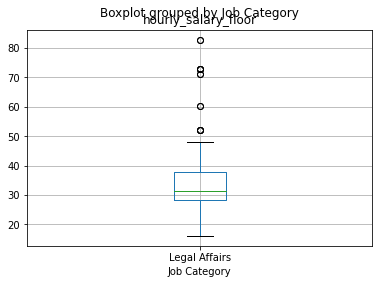

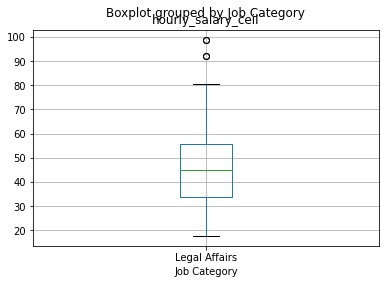

In [71]:
plot_salary_distribution(df = normalized_df,
                            input_category='Legal Affairs',
                            target_colnames=['hourly_salary_floor','hourly_salary_ceil'])

In [75]:
def comparing_distributions(df:DataFrame,
                           categories:list,
                           input_colname:str='Job Category',
                            target_colname: str = 'hourly_salary_floor'
                           ) -> None:
    
    # Iterate through each chosen category
    plot_df = df.toPandas()
    for category in categories:
        # Subset to the category
        subset = plot_df[plot_df[input_colname] == category]

        sns.distplot(subset[target_colname],
                     hist = False,
                     kde = True,
                     kde_kws = {'linewidth': 3},
                     label = category)
    
    # Plot formatting
    plt.legend(prop={'size': 6}, title = 'Category')
    plt.title('Density Plot with Multiple Job Categories')
    plt.xlabel('Salary floor')
    plt.ylabel('Density')

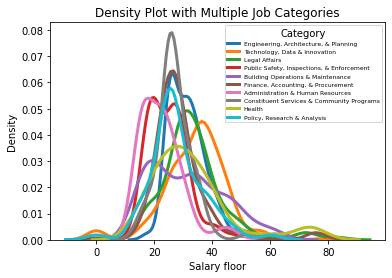

In [76]:
categories = ['Engineering, Architecture, & Planning',
                  'Technology, Data & Innovation',
                  'Legal Affairs',
                  'Public Safety, Inspections, & Enforcement',
                  'Building Operations & Maintenance',
                  'Finance, Accounting, & Procurement',
                  'Administration & Human Resources',
                  'Constituent Services & Community Programs',
                  'Health',
                  'Policy, Research & Analysis']
comparing_distributions(normalized_df, categories)

**3. Is there any correlation between the higher degree and the salary?**

Yes, below is the plot that shows this correlation.

On average, the higher the degree, the higher the salary.

There are some very noticable outliers, which could be explained by longer years of work experience, higher level, or could be incorrect data

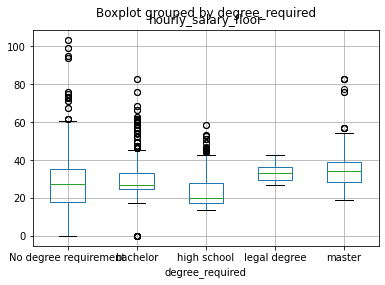

In [135]:
cleaned_df = text_cleaner(denoise_df)
enriched_df = extract_degree_info(cleaned_df)

degree_df_plot = enriched_df.toPandas()
degree_df_plot.boxplot(column='hourly_salary_floor',by='degree_required',)

**3. Whats the job posting having the highest salary per agency?**

Let's look at a few agencies:

`NYC EMPLOYEES RETIREMENT SYS` - Job ID 413546 , the internal and external posting type have the same salary

`FIRE DEPARTMENT` - Job ID 420326 

`TAX COMMISSION` - Job ID 423630

In [142]:
def top_salary_by_agency(df:DataFrame,
                         agency:str) -> DataFrame:
    
    """Use this function to look at the highest salary of a selected agency"""

    windowSpec = Window.partitionBy('Agency').orderBy(col('hourly_salary_ceil').desc())

    res_df = df \
    .withColumn('ranking',dense_rank().over(windowSpec)) \
    .select('Job ID','Agency','Posting Type','hourly_salary_ceil','ranking') \
    .filter(col('Agency')==agency) \
    .filter(col('ranking')==1)
    
    return res_df

In [143]:
res = top_salary_by_agency(normalized_df,'NYC EMPLOYEES RETIREMENT SYS')
res.show(truncate=False)

+------+----------------------------+------------+------------------+-------+
|Job ID|Agency                      |Posting Type|hourly_salary_ceil|ranking|
+------+----------------------------+------------+------------------+-------+
|413564|NYC EMPLOYEES RETIREMENT SYS|Internal    |110.98579545454545|1      |
|413564|NYC EMPLOYEES RETIREMENT SYS|External    |110.98579545454545|1      |
+------+----------------------------+------------+------------------+-------+



In [144]:
res = top_salary_by_agency(normalized_df,'FIRE DEPARTMENT')
res.show(truncate=False)

+------+---------------+------------+------------------+-------+
|Job ID|Agency         |Posting Type|hourly_salary_ceil|ranking|
+------+---------------+------------+------------------+-------+
|420216|FIRE DEPARTMENT|Internal    |68.62168560606061 |1      |
+------+---------------+------------+------------------+-------+



In [145]:
res = top_salary_by_agency(normalized_df,'TAX COMMISSION')
res.show(truncate=False)

+------+--------------+------------+------------------+-------+
|Job ID|Agency        |Posting Type|hourly_salary_ceil|ranking|
+------+--------------+------------+------------------+-------+
|423630|TAX COMMISSION|Internal    |42.69744318181818 |1      |
|423630|TAX COMMISSION|External    |42.69744318181818 |1      |
+------+--------------+------------+------------------+-------+



**4. Whats the job positings average salary per agency for the last 2 years?**

The latest data we have in Posting Date is : 2019-12-17 0:00:00

So the timeframe to use is 2017-12-17 - 2019-12-17

In [112]:
filtered_df = normalized_df.filter(col('Posting Date') >= '2017-12-17')


In [115]:
filtered_df.groupBy('Agency').agg(avg('hourly_salary_ceil').alias('average salary')).show(52)

+--------------------+------------------+
|              Agency|    average salary|
+--------------------+------------------+
|LANDMARKS PRESERV...|30.443655303030305|
|     FIRE DEPARTMENT| 44.16099944903581|
|ADMIN FOR CHILDRE...| 41.23856070632797|
|MANHATTAN COMMUNI...|              19.0|
|      TAX COMMISSION|28.589930555555554|
|HRA/DEPT OF SOCIA...|40.515165738025416|
|TAXI & LIMOUSINE ...|34.437856490275884|
|EQUAL EMPLOY PRAC...|31.942945075757578|
|DEPARTMENT OF BUS...| 37.78679296969697|
|DEPT OF DESIGN & ...|54.373146073410155|
|TEACHERS RETIREME...|35.871212121212125|
|FINANCIAL INFO SV...| 52.92115713587488|
|DEPARTMENT OF COR...| 41.94011595365419|
|OFFICE OF EMERGEN...|40.246212121212125|
|HOUSING PRESERVAT...| 40.53387618921776|
|CIVILIAN COMPLAIN...| 35.16653547237076|
|OFFICE OF MANAGEM...|36.696070075757575|
|MAYORS OFFICE OF ...|47.044101731601714|
|DEPT OF CITYWIDE ...|42.171325757575765|
|DEPARTMENT OF CIT...| 37.93087121212121|
|ADMIN TRIALS AND ...|20.615969333

**5. What are the highest paid skills in the US market?**

In [ ]:
cleaned_df = text_cleaner(denoise_df)
enriched_df = extract_degree_info(cleaned_df)
skills_df = extract_skills(enriched_df)


In [ ]:
# create DataFrame: skill, average salary of a job with that skill, max salary of a job with that skill, 
skills_df.groupBy('skill').agg(avg('hourly_salary_ceil').alias('avg_salary'),
                         max('hourly_salary_ceil').alias('max_salary')).sort('avg_salary',ascending=False).show(50)


In [ ]:
# Write results to a location
location = './out/ml_files/ml_features_20230408.parquet'
df.write.mode('overwrite').parquet(location)

# Tests

In [131]:
mock_data = [('1001',0),('1002',100),('1003',300)]
def test_handle_outliers(mock_data: list,
                        expected_result: int,
                        schema: list = ['id', 'salary']):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    
    filtereddf = handle_outliers(mock_df,'salary',1,None)
    resdf = filtereddf.select(min('salary'))
    res = resdf.head()[0]

    assert res == expected_result , "expected {}, got {}".format(expected_result, res)

test_handle_outliers(mock_data,100)

In [9]:
mock_data = [('A',10),('B',1),('C',2),('A',1),('B',1),('B',1)]

def test_count_posting_per_category(mock_data: list,
                                    expected_result:str,
                                    schema:list=['category','count']
):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    resdf = count_posting_per_category(mock_df,'category')
    res = resdf.head()[0]
    assert res == expected_result, "expected {}, got {}".format(expected_result, res)
    
test_count_posting_per_category(mock_data, 'B')

In [109]:
mock_data = [('Annual',None,'2023-01-01','2023-01-01','2023-01-01'),
             ('Hourly',None,'2023-01-01',None,'2023-01-01'),
             ('Annual','F','2023-01-01','2023-01-01','2023-01-01'),
             ('Daily',None,'2023-01-01','2023-01-01','2023-01-01'),
             ('Daily','P','2023-01-01', None, None)]

def test_handle_null_values(mock_data: list,
                            expected_result:int,
                            schema:list=['Salary Frequency',
                                         'Full-Time/Part-Time indicator',
                                        'Posting Date',
                                         'Posting Updated',
                                         'Process Date'
                                        ]):
    mock_df = spark.createDataFrame(data=mock_data, schema=schema)
    resdf = handle_null_values(mock_df) \
    .drop('Full-Time/Part-Time indicator',
            'Posting Date',
            'Posting Updated',
            'Process Date')
    
    count_null = 0
    for column in clean_df.columns:
        n = clean_df.filter(col(column).isNull()).count()
        count_null += n
    
    assert count_null == expected_result
    
test_handle_null_values(mock_data,0)

In [ ]:
mock_data = [("Job 1", "Agency A", "Type 1", 25),
             ("Job 2", "Agency A", "Type 1", 30),
             ("Job 3", "Agency B", "Type 1", 20),
             ("Job 4", "Agency B", "Type 2", 35),
             ("Job 5", "Agency A", "Type 2", 40)]

def test_top_salary_by_agency():
    expected_output = [("Job 2", "Agency A", "Type 1", 30, 1),
                       ("Job 5", "Agency A", "Type 2", 40, 1)]
    
    result = top_salary_by_agency(df, "Agency A").toPandas()
    
    pd.testing.assert_frame_equal(result, pd.DataFrame(expected_output, columns=["Job ID", "Agency", "Posting Type", "hourly_salary_ceil", "ranking"]))

# run the test
test_top_salary_by_agency()

In [5]:
# mock_data = [('A', 'Annual'), ('B', 'Daily')]
# expected_result = ['Annual', 'Daily']

In [6]:
# def test_get_salary_frequency(mock_data: list, 
#                               expected_result: list,
#                               schema: list = ['id', 'Salary Frequency']):  
#     mock_df = spark.createDataFrame(data = mock_data, schema = schema)
#     assert get_salary_frequency(mock_df) == expected_result